In [1]:
%matplotlib widget

In [2]:
from functools import partial

In [3]:
from libschrodinger import *

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
from pathlib import Path

In [7]:
from typing import Dict

In [8]:
caseName : str = "test_option_0"

In [9]:
math = np

In [10]:
spatialStep : float = .01
length : float = 4
temporalStep : float = (spatialStep ** 2) / 4
courantNumber : float = 1.0
pointCount : int = int(length / spatialStep)
potentialHeight : float = 1000
preRegionLength = .3
preRegionScalar = 2
packetStandardDeviation : float = preRegionLength / preRegionScalar
packetStartX : float = 1 - ((preRegionScalar / 2) * packetStandardDeviation)
packetStartY : float = .5
packetWaveNumber : float = 13 * np.pi
barrierCount : int = 3
postRegionLength = .3
intraRegionLength : float = 1 - (postRegionLength + preRegionLength)
barrierWidth : float = intraRegionLength / barrierCount
constantPotentialLengthRatios : List[float] = [postRegionLength] \
        + ([barrierWidth] * barrierCount) \
        + [preRegionLength]
print("Point Count: ", pointCount)
print("Post Region Length: ", postRegionLength)
print("Intra Region Length: ", intraRegionLength)
print("Pre Region Length: ", preRegionLength)
print("Barrier Length: ", barrierWidth)
print("Total Length: ", intraRegionLength + postRegionLength + preRegionLength)
print("Total Length Ratios: ", np.sum(constantPotentialLengthRatios))
frameCount : int = 60

Point Count:  400
Post Region Length:  0.3
Intra Region Length:  0.4
Pre Region Length:  0.3
Barrier Length:  0.13333333333333333
Total Length:  1.0
Total Length Ratios:  1.0


In [11]:
wavePacketFunction = lambda position : makeWavePacket(
            position, 
            packetStartX * length, 
            packetStartY * length, 
            spatialStep, 
            packetStandardDeviation, 
            packetWaveNumber, 
            math
        )

In [12]:
potentials : List[List[float]] = [
        [0, 0, 1, 1, 1], 
    ]

In [13]:
profiles : List[SimulationProfile] = constantSimulationProfiles(
        wavePacketFunction, 
        spatialStep, 
        temporalStep, 
        length, 
        constantPotentialLengthRatios, 
        potentials, 
        potentialHeight, 
        pointCount, 
        True, 
        edgeBound = True, 
        logFunction = performenceLog
    )

In [14]:
constantPotentialLengthRatios

[0.3, 0.13333333333333333, 0.13333333333333333, 0.13333333333333333, 0.3]

In [15]:
allData, _, logs = recordConstantRegionSimulations(
        profiles, 
        frameCount, 
        caseName, 
        constantPotentialLengthRatios, 
        True, 
        constantRegionLabels = ["Post", "3rdStair", "2ndStair", "1stStair", "Pre"], 
        showBar = True, 
        showFPS = True, 
        showTotalTime = True
    )

[====================================================================================================]
[--------------------------------------------------------------------------------------------------]
Total Time:  107.00142900300125
Frames Per Second:  0.5445422155401295
Simulation 0 is done, processing probabilities.
Simulation 0: done processing probabilities.
Simulation 0: logging.
Saving Video of test_option_00
Saving Video of Post
Saving Video of 3rdStair
Saving Video of 2ndStair
Saving Video of 1stStair
Saving Video of Pre
Done logging test_option_00
Producing Simulation final output CSV
[====================================================================================================]
[--------------------------------------------------------------------------------------------------]
Total Time:  106.48716248299934
Frames Per Second:  0.5385305424822545
Simulation 1 is done, processing probabilities.
Simulation 1: done processing probabilities.
Simulation 1: logging.
Savin

In [16]:
allData["packetStartX"] = packetStartX
allData["packetStartY"] = packetStartY
allData["initialWaveNumber"] = packetWaveNumber
allData["standardDeviation"] = packetStandardDeviation

In [17]:
pd.DataFrame(allData).to_csv(str(Path.cwd() / caseName / (caseName + ".csv")))

In [18]:
keys = list(logs[0].keys())
for key in keys: 
    print(len(logs[0][key]))
keys

1
1
1
59
59
59
59
59
59
59
59
59


['Started Simulation',
 'Generated Initial Potential',
 'Generated Next Initial Potential',
 'Starting "Step"',
 'Created knownStepMatrix',
 'Created unknownStepMatrix',
 'Started "Compute"',
 'Reshaped Wave Function',
 'Matrix Multiplication',
 'Solved For Independant Terms and Reshaped',
 'Appended Wave Function and Finished "Compute"',
 'Computed and Finished "Step"']

In [19]:
logKeyList = [
    'Starting "Step"',
    'Created knownStepMatrix',
    'Created unknownStepMatrix',
    'Started "Compute"',
    'Reshaped Wave Function',
    'Matrix Multiplication',
    'Solved For Independant Terms and Reshaped',
    'Appended Wave Function and Finished "Compute"',
    'Computed and Finished "Step"'
]

In [20]:
copiedLogs = []
logIndex = 0
logPath = Path.cwd() / caseName / "logs"
logPath.mkdir(exist_ok = True)
for log in logs: 
    logCopy = {}
    for key in logKeyList: 
        logCopy[key] = log[key]
    copiedLogs.append(logCopy)
    pd.DataFrame(logCopy).to_csv(str(logPath / (caseName + "_log_" + str(logIndex) + ".csv")))
    logIndex += 1

Starting "Step"
Created knownStepMatrix
Created unknownStepMatrix
Started "Compute"
Reshaped Wave Function
Matrix Multiplication
Solved For Independant Terms and Reshaped
Appended Wave Function and Finished "Compute"
Computed and Finished "Step"


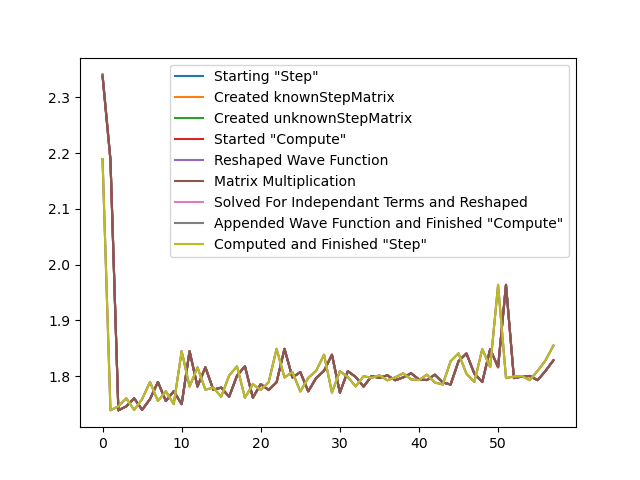

In [21]:
currentLog = copiedLogs[0]
plt.figure()
for stepLabel in logKeyList: 
    print(stepLabel)
    accelerated = np.array(currentLog[stepLabel])
    plt.plot(accelerated[1:] - accelerated[:-1], label=stepLabel)
plt.legend()

Starting "Step" -> Created knownStepMatrix
Created knownStepMatrix -> Created unknownStepMatrix
Created unknownStepMatrix -> Started "Compute"
Started "Compute" -> Reshaped Wave Function
Reshaped Wave Function -> Matrix Multiplication
Matrix Multiplication -> Solved For Independant Terms and Reshaped
Solved For Independant Terms and Reshaped -> Appended Wave Function and Finished "Compute"
Appended Wave Function and Finished "Compute" -> Computed and Finished "Step"


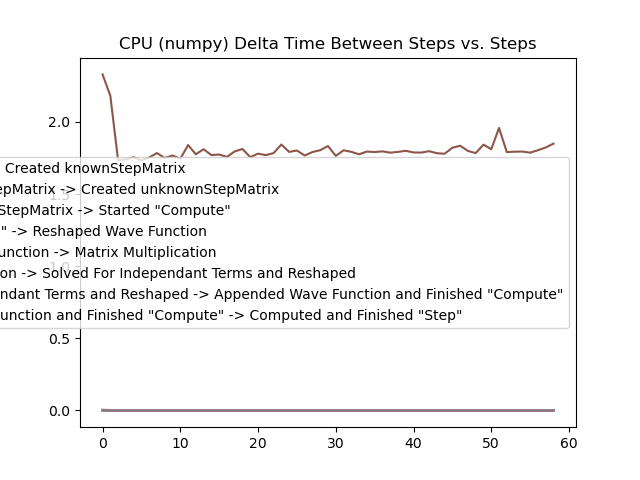

In [22]:
currentLog = copiedLogs[0]
plt.figure()
plt.title("CPU (numpy) Delta Time Between Steps vs. Steps")
for stepLabel, nextLabel in  list(zip(logKeyList[:-1], logKeyList[1:])): 
    label = stepLabel + " -> " + nextLabel
    print(label)
    acceleratedCurrent = np.array(currentLog[stepLabel])
    acceleratedNext = np.array(currentLog[nextLabel])
    plt.plot(acceleratedNext - acceleratedCurrent, label=label)
plt.legend()